# E91 QKD with Bell‐Inequality Test
This notebook implements the E91 entanglement-based QKD protocol
and applies a CHSH Bell‐inequality test to detect eavesdroppers.

## 1. Imports & Setup

In [38]:
%pip install qiskit
%pip install --upgrade typing_extensions
%pip install qiskit-aer
%pip install pylatexenc

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import secrets
import pathlib
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator

# Simulator backend
backend = AerSimulator()
rng = secrets.SystemRandom()

## 2. Parameters

In [2]:
# User parameters
IMG_PATH        = pathlib.Path('download.png')
BLOCK_SIZE      = 10

# Ensure image exists and read bytes
if not IMG_PATH.exists():
    raise FileNotFoundError(f'Missing {IMG_PATH}')
    
# Read the bytes from the image
img_bytes  = IMG_PATH.read_bytes()
n_img_bits = len(img_bytes) * 8
print(f"Image bits to secure: {n_img_bits}")

Image bits to secure: 30752


## 3. Utility Functions

In [3]:
# Random n bits generator 
def random_bits(n):
    return np.random.randint(2, size=n, dtype=int)

# Map measurement outcomes {0,1} → eigenvalues {-1,+1} for CHSH correlation
def to_pm1(bits):
    return 1 - 2 * np.array(bits, dtype=int)

# Compute the CHSH correlator E(a,b) = ⟨A·B⟩ over rounds where Alice’s and Bob’s settings equal (a,b)
def correlation(a, b, A_set, B_set, A_res, B_res):
    idx = (np.array(A_set)==a)&(np.array(B_set)==b)
    if idx.sum()==0:
        return np.nan
    A = to_pm1(np.array(A_res)[idx])
    B = to_pm1(np.array(B_res)[idx])
    return np.mean(A*B)

# Turns bits into bytes using numpy
def bits_to_bytes(bits):
    arr    = np.array(bits, dtype=np.uint8)
    packed = np.packbits(arr)
    return packed.tobytes()

## 4. E91 Emitter & Measurement Circuits

In [4]:
def emitter_circuit(size):
    qc = QuantumCircuit(2*size, 2*size, name='Emitter')
    for i in range(size):
        qc.h(i)
        qc.cx(i, i+size)
        qc.z(i)  # |Φ+> -> |Ψ-> singlet
    return qc

def measure_circuit(alice_bases, bob_bases):
    angles = {0: 0, 1: np.pi/4}
    qc = QuantumCircuit(2*len(alice_bases), 2*len(alice_bases), name='Measure')
    for i, (a, b) in enumerate(zip(alice_bases, bob_bases)):
        qc.ry(-angles[a], i)
        qc.ry(-angles[b], i+len(alice_bases))
    qc.measure(range(2*len(alice_bases)), range(2*len(alice_bases)))
    return qc

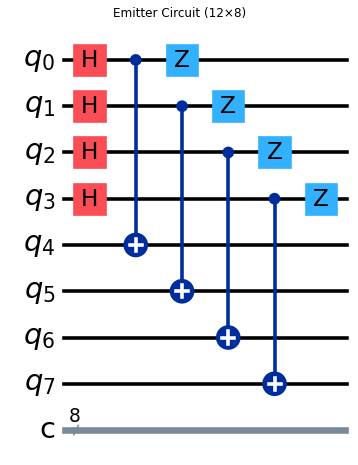

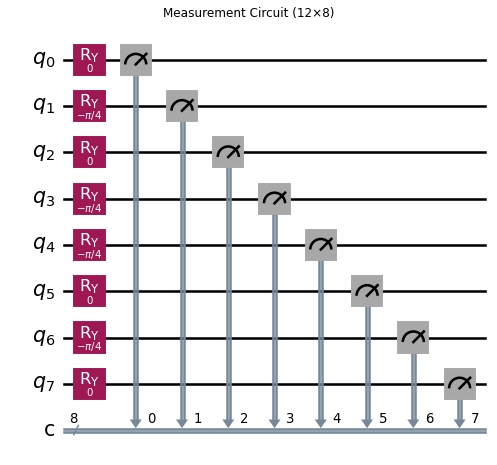

In [13]:
import matplotlib.pyplot as plt
from qiskit.visualization import circuit_drawer

# --- Assume emitter_circuit and measure_circuit are already defined ---
qc_emitter = emitter_circuit(4)
qc_measure = measure_circuit([0, 1, 0, 1], [1, 0, 1, 0])

# Option 1: Increase figure size
fig_em1, ax_em1 = plt.subplots(figsize=(12, 8))
circuit_drawer(qc_emitter, output='mpl', ax=ax_em1)
ax_em1.set_title("Emitter Circuit (12×8)")

fig_me1, ax_me1 = plt.subplots(figsize=(12, 8))
circuit_drawer(qc_measure, output='mpl', ax=ax_me1)
ax_me1.set_title("Measurement Circuit (12×8)")

plt.show()

# Option 2: Use the `scale` parameter to enlarge gate labels
fig_em2 = qc_emitter.draw(output='mpl', scale=2.0)
fig_em2.suptitle("Emitter Circuit (scale=2.0)")

fig_me2 = qc_measure.draw(output='mpl', scale=2.0)
fig_me2.suptitle("Measurement Circuit (scale=2.0)")

plt.show()

## 5. Run Protocol & Collect Data

In [22]:
# Collect data for CHSH
alice_settings = []
bob_settings   = []
alice_results  = []
bob_results    = []
alice_key = []
bob_key = []

rounds = 0
while len(alice_key) < n_img_bits:
    # Increments round count and generates random basis for each side
    rounds += 1
    bases_A = random_bits(BLOCK_SIZE)
    bases_B = random_bits(BLOCK_SIZE)
    
    # Build and run the E91 entangler + measurement circuit 
    qc = emitter_circuit(BLOCK_SIZE).compose(measure_circuit(bases_A, bases_B))
    compiled = transpile(qc, backend)
    counts = backend.run(compiled, shots=1).result().get_counts()
    bitstr = next(iter(counts))
    meas = np.array(list(map(int, bitstr[::-1])))
    meas_A = meas[:BLOCK_SIZE]
    meas_B = meas[BLOCK_SIZE:]
    
    # Record for Bell test
    alice_settings.extend(bases_A.tolist())
    bob_settings.extend(bases_B.tolist())
    alice_results.extend(meas_A.tolist())
    bob_results.extend(meas_B.tolist())
    
    # Sift key
    mask = bases_A == bases_B
    alice_key.extend(meas_A[mask].tolist())
    bob_key.extend(meas_B[mask].tolist())
    
    if rounds % 10 == 0:
        print(f"Round {rounds}: collected {len(alice_key)} bits", end='\r')
print()
print(f"Total rounds: {rounds}")

Round 6090: collected 30724 bits
Total rounds: 6096


## 6. Bell‐Inequality (CHSH) Test

In [28]:
E00 = correlation(0,0, alice_settings, bob_settings, alice_results, bob_results)
E01 = correlation(0,1, alice_settings, bob_settings, alice_results, bob_results)
E10 = correlation(1,0, alice_settings, bob_settings, alice_results, bob_results)
E11 = correlation(1,1, alice_settings, bob_settings, alice_results, bob_results)

S = E00 + E01 + E10 - E11

print(f"E00={E00:.3f}, E01={E01:.3f}, E10={E10:.3f}, E11={E11:.3f}")
print(f"CHSH S={S:.3f}")
if S > 2:
    print("✅ Bell violation detected — channel secure")
else:
    print("⚠️ No violation — possible eavesdropper")

E00=1.000, E01=0.704, E10=0.713, E11=-0.000
CHSH S=2.418
✅ Bell violation detected — channel secure


## 7. Encrypt & Decrypt Image

In [23]:
# Use first n_img_bits from sifted key
key_bits = bob_key[:n_img_bits]

key_bytes = bits_to_bytes(key_bits)
cipher = bytes(m ^ k for m, k in zip(img_bytes, key_bytes))
dec = bytes(c ^ k for c, k in zip(cipher, key_bytes))

dec_path = IMG_PATH.with_name(IMG_PATH.stem + '_decrypted.png')
dec_path.write_bytes(dec)

if dec == img_bytes:
    print("✅ Image encrypted and decrypted successfully!")

✅ Image encrypted and decrypted successfully!
